# Tabla de contenidos
<a id="Inicio"></a>

1. [Abrir el archivo de datos y leer la información general](#paso1)
2. [Preparar los datos para el análisis](#paso2)
3. [Estudiar y comprobar los datos](#paso3)
   * [¿Qué periodo de tiempo cubren los datos?](#period)
   * [Traza un histograma por fecha y hora.](#hist)
   * [Asegúrate de tener usuarios y usuarias de los tres grupos experimentales.](#users_groups)
4. [ Estudiar el embudo de eventos](#paso4)
   * [¿En qué orden crees que ocurrieron las acciones? ¿Todas son parte de una sola secuencia?](#order)
   * [Utiliza el embudo de eventos para encontrar la proporción de usuarios y usuarias que pasan de una etapa a la siguiente.](#embudo)
   * [¿En qué etapa pierdes más usuarios y usuarias?](#stages)
5. [Estudiar los resultados del experimento](#paso5)
   * [¿Cuántos usuarios y usuarias hay en cada grupo?](#users_group)
   * [Tenemos dos grupos de control en el test A/A, donde comprobamos nuestros mecanismos y cálculos. Observa si hay una diferencia estadísticamente significativa entre las muestras 246 y 247.](#A/A)
   * [Comprueba si la diferencia entre los grupos es estadísticamente significativa. Repite el procedimiento para todos los demás eventos](#func)
   * [Compara los resultados con los resultados combinados de los grupos de control. ¿Qué conclusiones puedes sacar del experimento?](#results)
6. [Conclusiones](#conc)

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import scipy.stats as st
import numpy as np
import math as mth

# Paso 1. Abrir el archivo de datos y leer la información general
<a id="paso1"></a>
[Inicio](#Inicio)

In [3]:
logs = pd.read_csv('/Users/Christian/Documents/Portfolio/AB TEST PROJECT/logs_exp_us.csv', sep='\t')
logs.info()
print()
logs

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB



,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


<i> No hay valores ausentes, aunque algunas columnas no tienen el tipo de datos correcto. </i>

# Paso 2. Preparar los datos para el análisis
<a id="paso2"></a>
[Inicio](#Inicio)

In [4]:
logs.rename(columns={'EventName':'event', 'DeviceIDHash':'id', 'EventTimestamp':'ts', 'ExpId':'group'}, inplace=True)
logs

,event,id,ts,group
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


In [5]:
logs['id'] = logs['id'].astype(str)
logs['ts'] = pd.to_datetime(logs['ts'], unit='s')
logs['ts'] = logs['ts'].dt.strftime('%Y-%m-%d %H:%M:%S')
logs[['date','time']] = logs['ts'].str.split(' ', expand=True, n=1)
logs['group'] = logs['group'].astype('category')
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype   
---  ------  --------------   -----   
 0   event   244126 non-null  object  
 1   id      244126 non-null  object  
 2   ts      244126 non-null  object  
 3   group   244126 non-null  category
 4   date    244126 non-null  object  
 5   time    244126 non-null  object  
dtypes: category(1), object(5)
memory usage: 9.5+ MB


In [6]:
logs.head(2)

,event,id,ts,group,date,time
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25,04:43:36
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25,11:11:42


In [7]:
logs.duplicated().sum()

np.int64(413)

In [8]:
dups = logs[logs.duplicated()]
dups.sort_values(by='ts').head(20)

,event,id,ts,group,date,time
453,MainScreenAppear,5613408041324010552,2019-07-30 08:19:44,248,2019-07-30,08:19:44
2350,CartScreenAppear,1694940645335807244,2019-07-31 21:51:39,248,2019-07-31,21:51:39
3573,MainScreenAppear,434103746454591587,2019-08-01 02:59:37,248,2019-08-01,02:59:37
4076,MainScreenAppear,3761373764179762633,2019-08-01 03:47:46,247,2019-08-01,03:47:46
4803,MainScreenAppear,2835328739789306622,2019-08-01 04:44:01,248,2019-08-01,04:44:01
5641,CartScreenAppear,4248762472840564256,2019-08-01 05:36:04,248,2019-08-01,05:36:04
5875,PaymentScreenSuccessful,6427012997733591237,2019-08-01 05:47:32,248,2019-08-01,05:47:32
7249,OffersScreenAppear,7224691986599895551,2019-08-01 06:44:06,246,2019-08-01,06:44:06
8065,CartScreenAppear,8189122927585332969,2019-08-01 07:18:49,248,2019-08-01,07:18:49
9179,MainScreenAppear,2230705996155527339,2019-08-01 07:54:47,246,2019-08-01,07:54:47


<i> Parece que existen 413 registros duplicados que al examinar más de cerca, denotan un posible problema con la pantalla de pago exitoso. </i>

In [9]:
logs = logs.drop_duplicates()
logs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 243713 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype   
---  ------  --------------   -----   
 0   event   243713 non-null  object  
 1   id      243713 non-null  object  
 2   ts      243713 non-null  object  
 3   group   243713 non-null  category
 4   date    243713 non-null  object  
 5   time    243713 non-null  object  
dtypes: category(1), object(5)
memory usage: 11.4+ MB


# Paso 3. Estudiar y comprobar los datos
<a id="paso3"></a>
[Inicio](#Inicio)

## ¿Cuántos eventos hay en los registros?
<a id="event_number"></a>
[Inicio](#Inicio)

In [10]:
logs['event'].count()

np.int64(243713)

<i> Tenemos un total de 243,713 registros de eventos. </i>

## ¿Cuántos usuarios y usuarias hay en los registros?
<a id="user_number"></a>
[Inicio](#Inicio)

In [11]:
logs['id'].nunique()

7551

<i> Hay 7,551 usuarios registrados. </i>

## ¿Cuál es el promedio de eventos por usuario?
<a id="avg_events"></a>
[Inicio](#Inicio)

In [12]:
logs.groupby('id')['event'].count().mean().round()

np.float64(32.0)

<i> En promedio cada usuario registró 32 eventos. </i>

## ¿Qué periodo de tiempo cubren los datos? Encuentra la fecha máxima y mínima.
<a id="period"></a>
[Inicio](#Inicio)

In [13]:
print(logs['ts'].min())
print(logs['ts'].max())

2019-07-25 04:43:36
2019-08-07 21:15:17


<i> El periódo comprendido es del 25 de julio al 07 de agosto. </i>

## Traza un histograma por fecha y hora. 
<a id="hist"></a>
[Inicio](#Inicio)

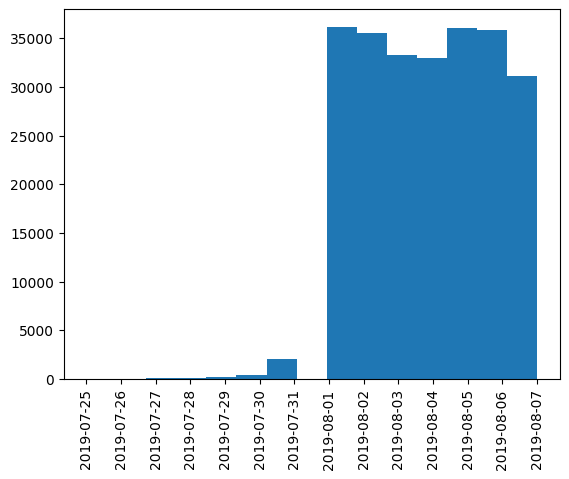

<Figure size 1000x500 with 0 Axes>

In [14]:
logs['date'].hist(grid=False, bins=15)
plt.xticks(rotation=90)
plt.figure(figsize=(10,5))
plt.show()

<i> Podemos observar que el grueso de los registros comienza el 01 de agosto, por lo que los datos realmente sólo representan el periódo del 01 al 07 de agosto. Con la finalidad de evitar sesgos en los datos, deberemos eliminar los registros previos a esta fecha. </i>

In [15]:
logs = logs[logs['date'] > '2019-08-01']
logs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 204746 entries, 39057 to 244125
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype   
---  ------  --------------   -----   
 0   event   204746 non-null  object  
 1   id      204746 non-null  object  
 2   ts      204746 non-null  object  
 3   group   204746 non-null  category
 4   date    204746 non-null  object  
 5   time    204746 non-null  object  
dtypes: category(1), object(5)
memory usage: 9.6+ MB


<i> El número de registros pasó de 243,713 a 204,746. Se excluyeron un total de 38,967 registros del periódo anterior al 01 de agosto, lo que representa el 16% del total de los registros. Considerando el tamaño de la muestra, es un porcentaje aceptable para continuar con el análisis. </i>

## Asegúrate de tener usuarios y usuarias de los tres grupos experimentales.
<a id="users_groups"></a>
[Inicio](#Inicio)

In [16]:
logs['group'].value_counts()

group
248    72289
246    67741
247    64716
Name: count, dtype: int64

<i> Conservamos una cantidad razonable de registros tanto de los grupos de control como del grupo experimental. </i>

# Paso 4. Estudiar el embudo de eventos
<a id="paso4"></a>
[Inicio](#Inicio)

## Observa qué eventos hay en los registros y su frecuencia de suceso. Ordénalos por frecuencia.

In [17]:
event_totals = logs.groupby('event')['id'].count().reset_index()
event_totals.rename(columns={'id':'total_logs'}, inplace=True)
event_totals = event_totals.sort_values(by='total_logs', ascending=False)
event_totals

,event,total_logs
1,MainScreenAppear,99383
2,OffersScreenAppear,39345
0,CartScreenAppear,36086
3,PaymentScreenSuccessful,29147
4,Tutorial,785


## Encuentra la cantidad de usuarios y usuarias que realizaron cada una de estas acciones. Ordena los eventos por el número de usuarios y usuarias. Calcula la proporción de usuarios y usuarias que realizaron la acción al menos una vez.

In [18]:
events = logs.groupby('event')['id'].nunique().reset_index().sort_values(by='id', ascending=False)
events.rename(columns={'id':'users'}, inplace=True)
events

,event,users
1,MainScreenAppear,7156
2,OffersScreenAppear,4380
0,CartScreenAppear,3571
3,PaymentScreenSuccessful,3399
4,Tutorial,690


In [19]:
fig0 = go.Figure(data=[go.Pie(labels=events['event'], values=events['users'])])
fig0.update_layout(title_text='Proporción de usuarios que realizaron la acción al menos una vez')
fig0.show()

## ¿En qué orden crees que ocurrieron las acciones? ¿Todas son parte de una sola secuencia? No es necesario tenerlas en cuenta al calcular el embudo.
<a id="order"></a>
[inicio](#Inicio)

<i> Podríamos pensar que la secuencia lógica de eventos sería MainScreenAppear > OffersScreenAppear > CartScreenAppear > PaymentScreenSuccessful y el tutorial aparece como una opción a ralizar dentro de la pantalla principal, de modo que algunos eligen tomarlo y otros no. Podemos inferir también que las acciones no necesariamente progresan de forma lineal, ya que alguien podría ver un producto en la pantalla principal y simplemente proceder al pago del mismo, o bien añadirlo al carrito pero no realizar el pago. </i>

## Utiliza el embudo de eventos para encontrar la proporción de usuarios y usuarias que pasan de una etapa a la siguiente.
<a id="embudo"></a>
[Inicio](#Inicio)

In [20]:
fig1 = go.Figure(go.Funnel(
    y = events['event'],
    x = events['users']
    ))
fig1.show()

## ¿En qué etapa pierdes más usuarios y usuarias?
<a id="stages"></a>
[Inicio](#Inicio)

<i> En el gráfico anterior podemos observar que perdemos más usuarios del evento MainScreenApper al evento OffersScreenAppear, con una reducción del 38.8% de usuarios. También podemos observar que del total de usuarios que inicio el proceso, tan sólo el 47.5% concluyó el pago. </i>

# Paso 5. Estudiar los resultados del experimento
<a id="paso5"></a>
[Inicio](#Inicio)

## ¿Cuántos usuarios y usuarias hay en cada grupo?
<a id="users_group"></a>
[Inicio](#Inicio)

In [21]:
print(f'El grupo A tiene {logs[logs["group"] == 246]["id"].nunique()} usuarios')
print(f'El grupo AA tiene {logs[logs["group"] == 247]["id"].nunique()} usuarios')
print(f'El grupo B tiene {logs[logs["group"] == 248]["id"].nunique()} usuarios')

El grupo A tiene 2393 usuarios
El grupo AA tiene 2434 usuarios
El grupo B tiene 2459 usuarios


## Tenemos dos grupos de control en el test A/A, donde comprobamos nuestros mecanismos y cálculos. Observa si hay una diferencia estadísticamente significativa entre las muestras 246 y 247.
<a id="A/A"></a>
[Inicio](#Inicio)

In [22]:
logs_A = logs[logs["group"] == 246]
logs_AA = logs[logs["group"] == 247]
logs_B = logs[logs["group"] == 248]

In [23]:
filtered_A = logs_A.groupby('event')['id'].nunique().reset_index().sort_values(by='id', ascending=False)
print(filtered_A)
print()
filtered_AA = logs_AA.groupby('event')['id'].nunique().reset_index().sort_values(by='id', ascending=False)
print(filtered_AA)
filtered_B = logs_B.groupby('event')['id'].nunique().reset_index().sort_values(by='id', ascending=False)

                     event    id
1         MainScreenAppear  2355
2       OffersScreenAppear  1480
0         CartScreenAppear  1213
3  PaymentScreenSuccessful  1152
4                 Tutorial   230

                     event    id
1         MainScreenAppear  2392
2       OffersScreenAppear  1438
0         CartScreenAppear  1184
3  PaymentScreenSuccessful  1118
4                 Tutorial   227


In [24]:
mainscreen_users = np.array([2355,2392])
paymentscreen_users = np.array([1152,1118])
alpha = .05

p1 = paymentscreen_users[0] / mainscreen_users[0]
p2 = paymentscreen_users[1] / mainscreen_users[1]

p_combined = (paymentscreen_users[0]+paymentscreen_users[1]) / (mainscreen_users[0]+mainscreen_users[1])

diff = p1 - p2

z_value = diff/mth.sqrt(p_combined*(1-p_combined)*(1/mainscreen_users[0] + 1/mainscreen_users[1]))

distr = st.norm(0,1)

p_value = (1-distr.cdf(abs(z_value)))*2

print('p-value: ', p_value)

if p_value < alpha:
    print("Rechazar la hipótesis nula: hay una diferencia significativa entre las proporciones")
else:
    print("No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes")


p-value:  0.13308725429290758
No se pudo rechazar la hipótesis nula: no hay razón para pensar que las proporciones son diferentes


In [25]:
merged_groups = pd.merge(filtered_A, filtered_AA, on='event').merge(filtered_B, on='event')
merged_groups.rename(columns={'id_x':'group_a', 'id_y':'group_aa', 'id':'group_b'}, inplace=True)


In [26]:
users_a = 2355
users_aa = 2392
users_b = 2409

merged_groups['conversion_a'] = merged_groups['group_a']/users_a
merged_groups['conversion_aa'] = merged_groups['group_aa']/users_aa
merged_groups['conversion_b'] = merged_groups['group_b']/users_b

merged_groups

,event,group_a,group_aa,group_b,conversion_a,conversion_aa,conversion_b
0,MainScreenAppear,2355,2392,2409,1.000000,1.000000,1.000000
1,OffersScreenAppear,1480,1438,1462,0.628450,0.601171,0.606891
2,CartScreenAppear,1213,1184,1174,0.515074,0.494983,0.487339
3,PaymentScreenSuccessful,1152,1118,1129,0.489172,0.467391,0.468659
4,Tutorial,230,227,233,0.097665,0.094900,0.096721


##  Selecciona el evento más popular. En cada uno de los grupos de control, encuentra la cantidad de usuarios y usuarias que realizaron esta acción. Encuentra su proporción. Comprueba si la diferencia entre los grupos es estadísticamente significativa. Repite el procedimiento para todos los demás eventos (ahorrarás tiempo si creas una función especial para esta prueba). ¿Puedes confirmar que los grupos se dividieron correctamente?

<a id="func"></a>
[Inicio](#Inicio)

In [27]:
def mw_test(df, event_col, group_col, group1, group2):
    results = []

    # Loop through each unique event
    for event in df[event_col].unique():
        # Filter data for the specific event and groups
        group1_data = df[(df[event_col] == event) & (df[group_col] == group1)]
        group2_data = df[(df[event_col] == event) & (df[group_col] == group2)]
        
        # Get the counts (number of occurrences) for each group
        counts_group1 = group1_data['id'].value_counts()
        counts_group2 = group2_data['id'].value_counts()
        
        # Perform the Mann-Whitney U test
        u_stat, p_value = st.mannwhitneyu(counts_group1, counts_group2, alternative='two-sided')
        
        # Determine significance
        significant_alpha_05 = "Yes" if p_value < 0.05 else "No"
        significant_alpha_1 = "Yes" if p_value < 0.1 else "No"
        
        # Append results
        results.append([event, p_value, significant_alpha_05, significant_alpha_1])

    return pd.DataFrame(results, columns=['event', 'p_value', 'alpha_0.05', 'alpha_0.1'])

##  Haz lo mismo para el grupo con fuentes alteradas. Compara los resultados con los de cada uno de los grupos de control para cada evento de forma aislada. Compara los resultados con los resultados combinados de los grupos de control. ¿Qué conclusiones puedes sacar del experimento?
<a id="results"></a>
[Inicio](#Inicio)

In [28]:
results_246_248 = mw_test(logs, 'event', 'group', 246, 248)

print("Results between groups 246 and 248:")
print(results_246_248)

Results between groups 246 and 248:
                     event   p_value alpha_0.05 alpha_0.1
0         CartScreenAppear  0.067182         No       Yes
1         MainScreenAppear  0.410395         No        No
2  PaymentScreenSuccessful  0.430750         No        No
3       OffersScreenAppear  0.719259         No        No
4                 Tutorial  0.297020         No        No


<i><b> Con un nivel de significancia en .05, no parece haber una diferencia significativa, pero con alpha = 0.1 sí existe una diferencia en el evento de CartScreenAppear. Esto sugiere que dependiendo del margen de error que queramos aceptar, el resultado en este evento puede requerir o no mayor investigación de nuestra parte.

In [29]:
results_247_248 = mw_test(logs, 'event', 'group', 247, 248)

print("\nResults between groups 247 and 248:")
print(results_247_248)


Results between groups 247 and 248:
                     event   p_value alpha_0.05 alpha_0.1
0         CartScreenAppear  0.007447        Yes       Yes
1         MainScreenAppear  0.148141         No        No
2  PaymentScreenSuccessful  0.035383        Yes       Yes
3       OffersScreenAppear  0.692051         No        No
4                 Tutorial  0.496780         No        No


<i><b> Con un nivel de significancia en .05 podemos concluir que existe una diferencia significativa en el desarrollo de los eventos CartScreenAppear y PaymentScreenAppear entre el grupo de control 247 y el grupo experimental 248. Esta diferencia permanece aún con el nivel de significancia en 0.1. Esto demuestra que existe un comportamiento diferente entre ambos grupos para esos dos eventos en específico.

In [30]:
results_246_247 = mw_test(logs, 'event', 'group', 246, 247)

print("\nResults between groups 246 and 247:")
print(results_246_247)


Results between groups 246 and 247:
                     event   p_value alpha_0.05 alpha_0.1
0         CartScreenAppear  0.437858         No        No
1         MainScreenAppear  0.517347         No        No
2  PaymentScreenSuccessful  0.205677         No        No
3       OffersScreenAppear  0.962710         No        No
4                 Tutorial  0.718566         No        No


<i><b> Con ambos niveles de significancia, los grupos de control no presentan diferencias significativas, lo que sugiere que el comportamiento de los usuarios en un grupo y otro no difiere demasiado.

# Conclusiones
<a id="conc"></a>
[Inicio](#Inicio)

<b> Analizando los datos, pese a diferencias muy puntuales que se revelaron tras las pruebas estadísticas, la información obtenida nos lleva a concluir que el comportamiento de los grupos de control y el experimental son muy similares. Las tasas de conversión y los embudos también sugieren un comportamiento muy similar. Con base en lo ya mencionado, resultaría factible detener la prueba y concluir que los eventos de CartScreenAppear y PaymentScreenAppear merecen mayor atención y análisis en los 3 grupos.